# Metaheuristic Algorithms
Following sections try some techniques from stochasitic optimization, also known as *metaheuristics*.

In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from alg import *
from utils import *

<AxesSubplot:xlabel='#resources', ylabel='min. makespan'>

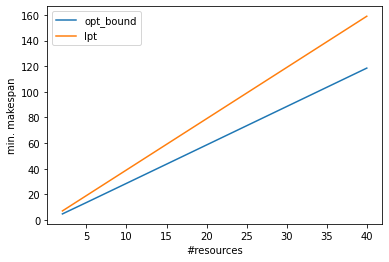

In [2]:
num_trials = 5
max_iters = 50

resources = [2, *range(5, 45, 5)]
problem_instances = [(R, suboptimal_instance(R)) for R in resources]

def eval_lpt(R, p):
    _, m, r, = lpt(R, p)
    return m / r, m

lpt_df = pd.DataFrame(data=(eval_lpt(R, p) for R, p in problem_instances), index=resources, columns=['opt_bound', 'lpt'])
lpt_df.plot.line(xlabel='#resources', ylabel='min. makespan')

## Simulated Annealing

### Sanity check
Note that the optimal value for this instance is 9.

In [3]:
_, makespan = anneal(R=3, p=[5, 5, 4, 4, 3, 3, 3])
makespan

9.0

### SA evaluation
Comparison of the solution quality between SA and LPT on problem instances for which LPT is known to be sub-optimal.

Because SA is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`.

Finally, SA is evaluated for each of the following *tweak* operators:
1. `vec_tweak` - for each task re-assign it to random resource with probabilyty `1/n` (`n` is no. tasks)
1. `point_tweak` - pick a task at random and assign it to random resource
1. `swap_tweak` - pick two tasks at random and swap the resources they are assigned to
each operator is then used with/witout fitness penalty `#unused resources * M` where `M` is some big-enough constant (marked with P).

In [4]:
def sa_makespan(R, p, tweak, penalize):
    _, m = anneal(R, p, tweak, max_iters, penalize=penalize)
    return m

def evaluate_sa(tweak, penalize):
    for R, p in problem_instances:
        yield sum(sa_makespan(R, p, tweak, penalize) for _ in range(num_trials)) / num_trials

In [5]:
tweak_df = pd.DataFrame({tweak.__name__: evaluate_sa(tweak, penalize=False) for tweak in [vec_tweak, point_tweak, swap_tweak]}, index=resources)
tweak_df = pd.concat([lpt_df, tweak_df], axis=1)
tweak_df

,opt_bound,lpt,vec_tweak,point_tweak,swap_tweak
2,4.666667,7.0,6.0,6.0,7.2
5,13.571429,19.0,16.8,16.8,20.8
10,28.536585,39.0,41.4,40.8,54.2
15,43.524590,59.0,70.0,69.8,71.8
20,58.518519,79.0,98.0,99.0,121.0
25,73.514851,99.0,133.8,135.2,147.4
30,88.512397,119.0,162.0,157.4,189.2
35,103.510638,139.0,201.4,198.4,213.2
40,118.509317,159.0,242.0,236.4,271.4


In [6]:
tweak_df.max()

opt_bound      118.509317
lpt            159.000000
vec_tweak      242.000000
point_tweak    236.400000
swap_tweak     271.400000
dtype: float64

<AxesSubplot:xlabel='#resources (R)', ylabel='min. makespan (mean for SA)'>

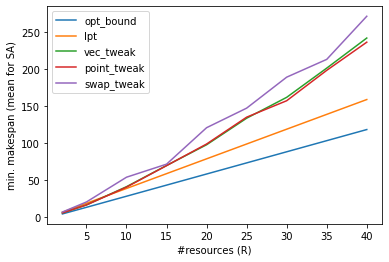

In [7]:
tweak_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for SA)')

Now let's try one of the better tweak operators with a penalty to solution quality. This penalty is equal to `#unused resources * M` where `M` is some big-enough constant (e.g. `M = sum(p)`).

<AxesSubplot:title={'center':'Effect of penalty to fitness for vec_tweak'}, xlabel='#resources (R)', ylabel='mean min. makespan'>

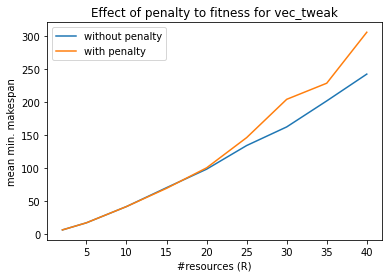

In [8]:
tweak_penalty_df = pd.DataFrame(
    {
        'without penalty': tweak_df['vec_tweak'],
        'with penalty': evaluate_sa(tweak=vec_tweak, penalize=True),
    },
    index=resources,
)
tweak_penalty_df.plot.line(xlabel='#resources (R)', ylabel='mean min. makespan', title='Effect of penalty to fitness for vec_tweak')

In [9]:
tweak_penalty_df.max()

without penalty    242.0
with penalty       305.4
dtype: float64

## Evolutionary strategies
- `(num_parents,pop_size)` ES - from a population of size `pop_size` select `num_parents` fittest individuals and create new population by tweaking them
- `(num_parents+pop_size)` ES - similar to `(num_parents,pop_size)` ES but parents get automatically promoted to next generation

### Sanity check
Note that the optimal value for this instance is 9.

In [10]:
_, makespan = evo_strat(R=3, p=[5, 5, 4, 4, 3, 3, 3], tweak=vec_tweak)
makespan

9.0

In [11]:
_, makespan = evo_strat(R=3, p=[5, 5, 4, 4, 3, 3, 3], tweak=vec_tweak, elitism=True)
makespan

9.0

### ES evaluation
Comparison of the solution quality between both ES and LPT on problem instances where LPT is known to be sub-optimal.

There are two main variants of ES (described above) with two main parameters:
 * `num_parents` - specifies how many fittests individuals participate in creating new generation
 * `pop_size` - specifies how many children are created in total each generation

Because ES is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`. Finally, all ES versions use `vec_tweak` as the mutation operator.

In [12]:
def es_makespan(R, p, num_parents, pop_size, elitism):
    _, m = evo_strat(
        R=R,
        p=p,
        num_parents=num_parents,
        pop_size=pop_size,
        elitism=elitism,
        max_iters=max_iters,
        penalize=False,
    )
    return m

def evaluate_es(num_parents, pop_size, elitism):
    for R, p in problem_instances:
        yield sum(es_makespan(R, p, num_parents, pop_size, elitism) for _ in range(num_trials)) / num_trials

In [13]:
def es_name(par, pop, elitism):
    op = '+' if elitism else ','
    return f'({par}{op}{pop}) ES'

es_df = pd.DataFrame(
    {
        es_name(num_parents, pop_size, elitism): evaluate_es(num_parents, pop_size, elitism)
        for num_parents in [5, 10]
        for pop_size in [100, 1000]
        for elitism in [False, True]
    },
    index=resources,
)
es_df = pd.concat([lpt_df, es_df], axis=1)
es_df

,opt_bound,lpt,"(5,100) ES",(5+100) ES,"(5,1000) ES",(5+1000) ES,"(10,100) ES",(10+100) ES,"(10,1000) ES",(10+1000) ES
2,4.666667,7.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
5,13.571429,19.0,16.4,16.4,16.0,15.4,16.0,16.8,15.6,15.4
10,28.536585,39.0,34.6,35.0,32.8,34.2,34.8,35.0,33.0,34.2
15,43.524590,59.0,53.0,52.6,51.8,51.6,53.2,54.0,50.8,52.4
20,58.518519,79.0,75.8,76.2,71.4,72.2,71.2,74.4,69.8,71.6
25,73.514851,99.0,96.0,101.6,91.6,91.8,94.8,98.0,90.6,89.8
30,88.512397,119.0,118.2,124.0,108.6,109.8,116.2,116.0,107.0,109.4
35,103.510638,139.0,142.6,141.4,131.2,133.6,138.8,149.2,130.4,132.2
40,118.509317,159.0,171.2,183.6,155.4,154.0,162.0,173.8,150.0,159.8


In [14]:
es_df.max()

opt_bound       118.509317
lpt             159.000000
(5,100) ES      171.200000
(5+100) ES      183.600000
(5,1000) ES     155.400000
(5+1000) ES     154.000000
(10,100) ES     162.000000
(10+100) ES     173.800000
(10,1000) ES    150.000000
(10+1000) ES    159.800000
dtype: float64

<AxesSubplot:title={'center':'Quality relative to LPT for R=40'}, ylabel='norm. quality(ES)/quality(LPT)'>

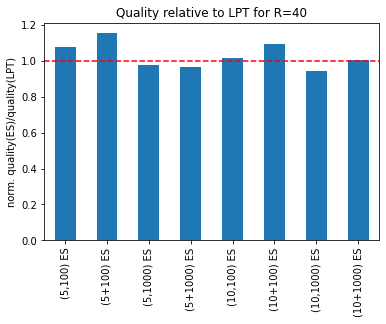

In [15]:
es_max_lpt_ratio = es_df - es_df.opt_bound
es_max_lpt_ratio = (es_df.loc[40] / es_df.lpt.loc[40])
es_max_lpt_ratio.drop(['opt_bound', 'lpt'], inplace=True)

ax = es_max_lpt_ratio.plot.bar(ylabel='norm. quality(ES)/quality(LPT)', title='Quality relative to LPT for R=40')
ax.axhline(y=1, color='r', linestyle='--')
ax

<AxesSubplot:title={'center':'Quality for ES configs better than LPT'}, xlabel='#resources (R)', ylabel='min. makespan (mean for ES)'>

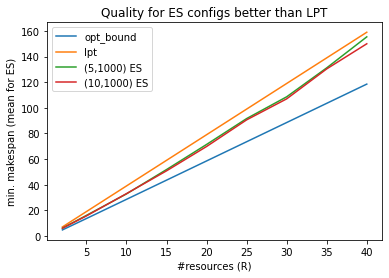

In [16]:
good_es_df = pd.concat((es_df[c] for c in es_df.columns if all(es_df[c] <= es_df.lpt) and '+' not in c), axis=1)
good_es_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for ES)', title='Quality for ES configs better than LPT')

# Evolutionary algorithms

### Sanity check
Note that the optimal value for this instance is 9.

In [17]:
_, makespan = evolve(R=3, p=[5, 5, 4, 4, 3, 3, 3], mate=two_point_crossover, mutate=mutation(vec_tweak, R=3))
makespan

9.0

### EA evaluation
Comparison of the solution quality between EA and LPT on problem instances for which LPT is known to be sub-optimal.

Because EA is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`.

Finally, EA uses `vec_tweak` as the mutation operator, `two_point_crossover` as the mating operator and we run it for 
* varying population sizes: 10, 100
* with/witout fitness penalty `#unused resources * M` where `M` is some big-enough constant (marked with P)

In [18]:
def ea_makespan(R, p, pop_size, generations, penalize):
    _, m = evolve(
        R=R,
        p=p,
        mate=two_point_crossover,
        mutate=mutation(vec_tweak, R),
        pop_size=pop_size,
        max_iters=generations,
        penalize=penalize,
    )
    return m

def evaluate_ea(pop_size, generations, penalize):
    for R, p in problem_instances:
        yield sum(ea_makespan(R, p, pop_size, generations, penalize) for _ in range(num_trials)) / num_trials

In [19]:
ea_pop_df = pd.DataFrame({f'EA-p{pop_size}-g{max_iters}': evaluate_ea(pop_size=pop_size, generations=max_iters, penalize=False) for pop_size in [100, 1000]}, index=resources)
ea_gen_df = pd.DataFrame({f'EA-p100-g{gens}': evaluate_ea(pop_size=100, generations=gens, penalize=False) for gens in [100, 1000]}, index=resources)
ea_df = pd.concat([lpt_df, ea_pop_df, ea_gen_df], axis=1)

In [20]:
ea_df.max()

opt_bound        118.509317
lpt              159.000000
EA-p100-g50      187.000000
EA-p1000-g50     194.200000
EA-p100-g100     174.800000
EA-p100-g1000    150.600000
dtype: float64

<AxesSubplot:title={'center':'Quality of various EA configurations'}, xlabel='#resources (R)', ylabel='min. makespan (mean for EA)'>

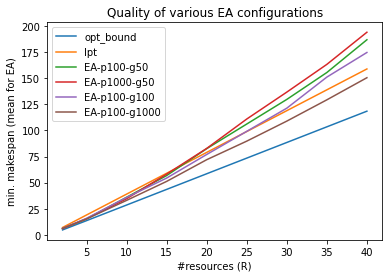

In [22]:
ea_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for EA)', title='Quality of various EA configurations')

Similarly to SA, let's check if using a penalty for unused resources helps to find better schedules.

<AxesSubplot:title={'center':'Effect of penalty to fitness for EA with population 100 and 1k generations'}, xlabel='#resources (R)', ylabel='min. makespan (mean for EA)'>

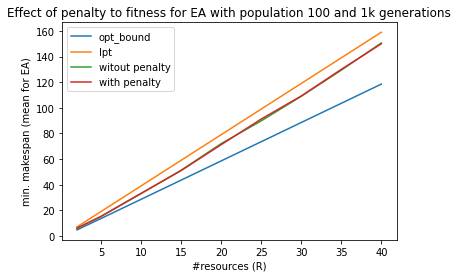

In [25]:
ea_penalty_df = pd.DataFrame(
    {
        'witout penalty': ea_df['EA-p100-g1000'],
        'with penalty': evaluate_ea(pop_size=100, generations=1000, penalize=True),
    },
    index=resources,
)
ea_penalty_df = pd.concat([lpt_df, ea_penalty_df], axis=1)
ea_penalty_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for EA)', title='Effect of penalty to fitness for EA with population 100 and 1k generations')

In [26]:
ea_penalty_df.max()

opt_bound         118.509317
lpt               159.000000
witout penalty    150.600000
with penalty      150.000000
dtype: float64